<font size="+2"><p style="text-align: center;"><b> Auswertung Versuch 233 PAP 2.1. </p></font>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.signal import argrelextrema

In [2]:
plt.rc('lines', linewidth=1.0, marker='.', markersize=3, markeredgewidth=0.4)
plt.rc('errorbar', capsize=2, )

In [3]:
def linear(x, a, b):
    return a*x + b


def linear_inv(y, a, b):
    return (y - b)/a

In [4]:
def beugung_spalt(x):
    return np.sinc(x)**2

In [5]:
# Ablesefehler der Positionsmessungen (in px):
px_error = 2.0

# Fehler an Counts bei einer Messung, sofern nicht bei der Einzelmessung anders angegeben
cnts_error = 10.0

# Brennweite von L1 in mm
f1 = 80.0

# Wellenlänge des Lasers in mm
lamb = 635e-6

# Breite eines Pixels in mm:
pxbreite = 14e-3

In [6]:
def beugung_doppelspalt(x, _g=0, _d=0, _v=0):
    if (_v == 0):
        return beugung_spalt(x) * np.cos(np.pi*_g/_d*x)**2
    else:
        return beugung_spalt(x) * np.cos(np.pi*_v*x)**2

## 3.1 Quantitative Beobachtungen am Einfachspalt

### Eichung der Abszisse

Zunächst bestimmen wir, wieviel Pixel auf der Kamera 1 mm in der Fourierebene entsprechen. Dazu wurde zu Beginn des Versuchs der Analysierspalt in der Fourierebene auf drei verschiedene Weiten eingestellt und die zugehörigen Abstände in Pixel auf dem Monitor abgelesen.

In [7]:
# Breiten in der Fourierebene (d.h. Öffnung des Analysierspalts)
x_fourier = np.array([1.1, 0.79, 0.615])*2
Dx_fourier = 0.01*2

# Breiten auf Kamera/Monitor:
x_kamera = np.array([1427.3, 1341.19, 1286.73]) - \
    np.array([642.82, 719.19, 785.69])
x_kamera_error = np.sqrt(2)*cnts_error
print(x_kamera)

[784.48 622.   501.04]


In [8]:
popt, pcov = curve_fit(linear, x_fourier, x_kamera,
                       sigma=np.repeat(x_kamera_error, 3))
conv_factor = popt[0]
conv_factor_error = np.sqrt(pcov[0][0])
print('Abstand Kamera / Abstand Fourierebene = ',
      conv_factor, ' +- ', conv_factor_error, ' px/mm')

Abstand Kamera / Abstand Fourierebene =  288.72109271652596  +-  21.686167114836902  px/mm


Somit entspricht ein Abstand von 1mm des Analysierspalts etwa $288.7 \pm 21.7$ Pixel auf dem Monitor. Wir tragen noch den Abstand auf dem Monitor über die Weite des Analysierspaltes auf.

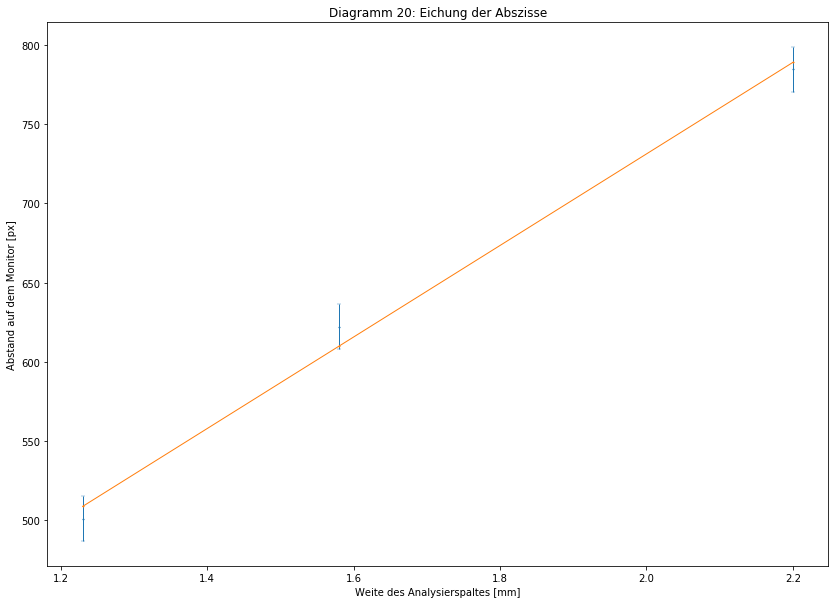

In [9]:
# plt.figure(figsize=(15,10))
plt.figure(figsize=(14, 10))
plt.errorbar(x_fourier, x_kamera, yerr=x_kamera_error, linestyle='none')
plt.plot(x_fourier, conv_factor*x_fourier + popt[1])
plt.xlabel('Weite des Analysierspaltes [mm]')
plt.ylabel('Abstand auf dem Monitor [px]')
plt.title('Diagramm 20: Eichung der Abszisse')
plt.savefig('fig/eichung.pdf', format='pdf')

### Berechnung der Spaltweite

In [10]:
# Position der Minima und Maxima in px (Werte aus Messreihe 2 mit hoher Intensität)
minima = np.array([951.61, 873.50, 795.40, 719.04, 639.20])
maxima = np.array([1029.71, 918.63, 837.06, 758.95, 682.59, 602.75])
n_minima = np.arange(1, 6)

Die Minima liegen für kleine Winkel $\alpha$ bei
$$n \cdot \lambda = d \cdot \sin(\alpha) \approx d \cdot \frac{x_\text{fourier}}{f_1}$$
d.h.
$$d \approx \lambda f_1 \cdot \frac{n}{x_\text{fourier}}$$

In [11]:
popt, pcov = curve_fit(linear, n_minima, minima, sigma=np.repeat(px_error, 5))
steigung = -popt[0]/conv_factor  # Umrechnung von Pixel in mm
steigung_error = steigung * \
    np.sqrt((np.sqrt(pcov[0][0])/popt[0])**2 +
            (conv_factor_error/conv_factor)**2)

In [12]:
d = lamb*f1/steigung
d_error = d*steigung_error/steigung
print('Spaltbreite: d = ', d, ' +- ', d_error, ' mm')

Spaltbreite: d =  0.1882126001920046  +-  0.01415142838100235  mm


In [13]:
print('Relativer Fehler der Spaltbreite: ', d_error/d)

Relativer Fehler der Spaltbreite:  0.07518852811430163


### Lage der experimentellen Beugungsmaxima

In [14]:
n_maxima = linear_inv(maxima, *popt)

maxima_error = np.repeat(px_error, maxima.size)
a_error = np.ones(maxima.size) * np.sqrt(pcov[0][0])
b_error = np.ones(maxima.size) * np.sqrt(pcov[1][1])

n_maxima_error = np.sqrt((maxima_error/popt[0])**2 + (np.sqrt(pcov[1][1])/popt[0])**2 +
                         ((maxima-popt[1])/popt[0]**2*np.sqrt(pcov[0][0]))**2)

print("Ordnungszahl n der gemessenen Beugungsmaxima:")
print(n_maxima)

print("Fehler der Ordnungszahlen:")
print(n_maxima_error)

Ordnungszahl n der gemessenen Beugungsmaxima:
[-2.25849456e-03  1.42315984e+00  2.46989529e+00  3.47223078e+00
  4.45210964e+00  5.47664511e+00]
Fehler der Ordnungszahlen:
[0.02804714 0.02846408 0.02928495 0.03044496 0.03189397 0.0336981 ]


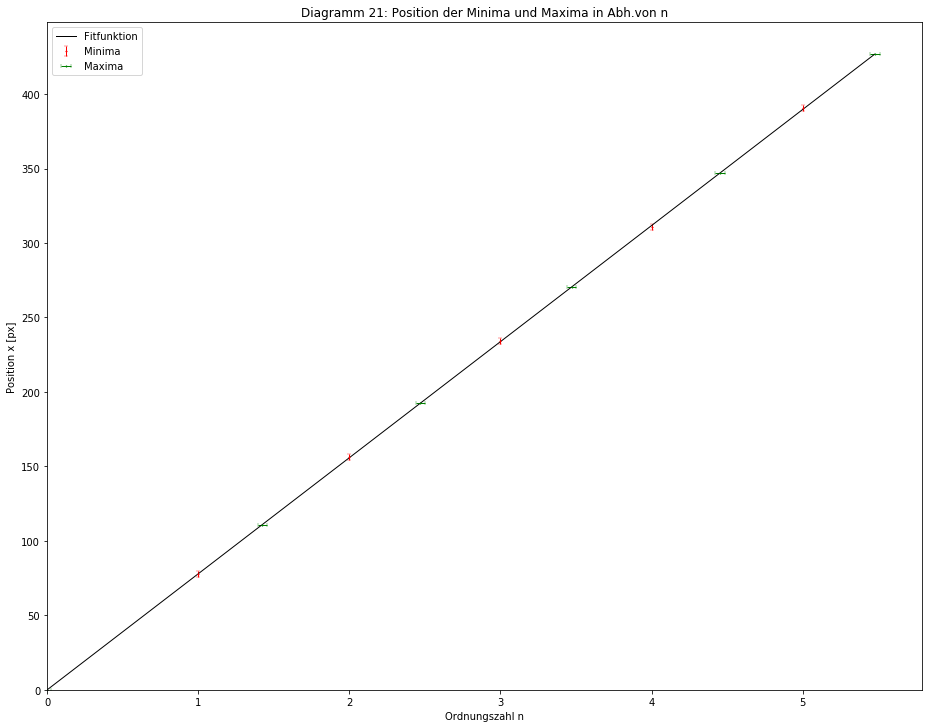

In [15]:
# plt.figure(figsize=(15,10))
plt.figure(figsize=(13, 10))
plt.errorbar(n_minima, popt[1] - minima, yerr=px_error,
             color='r', linestyle='none', label='Minima')
plt.errorbar(n_maxima, popt[1] - maxima, xerr=n_maxima_error,
             color='g', linestyle='none', label='Maxima')
plt.plot(n_maxima, popt[1] - linear(n_maxima, *popt),
         color='k', marker='', label='Fitfunktion')
plt.xlabel('Ordnungszahl n')
plt.ylabel('Position x [px]')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.legend()
plt.tight_layout()
plt.title('Diagramm 21: Position der Minima und Maxima in Abh.von n')
plt.savefig('fig/minima_maxima_pos.pdf')

### Lage der theoretischen Beugungsmaxima

In [16]:
# Numerische Bestimmung der theoretischen Maxima:
# Alternative analytische Bestimmung über die Fixpunktgleichung x = tan(x)
x = np.linspace(-6, 0.1, 10000)
intens_theo = beugung_spalt(x)
maxima_indices, maxima_prop = find_peaks(intens_theo, height=0)
nebenmaxima_theo = np.flip(maxima_prop['peak_heights'][:-1])

In [17]:
print('Theoretische Lage der Nebenmaxima in Abhängigkeit der Ordnungszahl n: ')

for i in range(1, 6):
    print('Maximum ' + str(i) + '-ter Ordnung: ' +
          str(np.flip(-x[maxima_indices])[i]))

Theoretische Lage der Nebenmaxima in Abhängigkeit der Ordnungszahl n: 
Maximum 1-ter Ordnung: 1.4300330033003306
Maximum 2-ter Ordnung: 2.45920592059206
Maximum 3-ter Ordnung: 3.470687068706871
Maximum 4-ter Ordnung: 4.477287728772877
Maximum 5-ter Ordnung: 5.481448144814482


In [18]:
# Berechnung der Differenz zwischen Theorie und Experiment
x_diff = np.abs(n_maxima - np.flip(-x[maxima_indices]))

print('Der Vergleich mit den theoretischen Werten liefert:')
print('∆n =       ' + str(x_diff))
print('mit Fehler:' + str(n_maxima_error))
print('in Sigma:  ' + str(x_diff/n_maxima_error))

Der Vergleich mit den theoretischen Werten liefert:
∆n =       [0.0023085  0.00687316 0.01068937 0.00154371 0.02517809 0.00480304]
mit Fehler:[0.02804714 0.02846408 0.02928495 0.03044496 0.03189397 0.0336981 ]
in Sigma:  [0.08230784 0.241468   0.36501226 0.05070489 0.78943096 0.14253139]


### Berechnung der Intensitätsverhältnisse der Nebenmaxima

Wir ermitteln nun die Intensitätsverhältnisse der gemessenen Nebenmaxima der 2. Messreihe relativ zum Maximum 0-ter Ordnung und vergleichen diese mit den theoretisch erwarteten Werten.

In [19]:
# Gemessene Intensitäten der Maxima und Minima (Messreihe 1 / Tabelle 2)
m1_max = np.array([3653.46, 291.13, 154.41, 120.78, 106.03, 96.31])
m1_min = np.array([88.33, 84.56, 83.09, 84.72, 82.88])

# Gemessene Intensitäten der Maxima und Minima (Messreihe 2 / Tabelle 3)
m2_max = np.array([3775.0, 1860.91, 975.31, 667.28, 461.36])
m2_min = np.array([300.04, 215.15, 149.32, 128.60, 119.60])

# Werte der Untergrundintensität aus dem Messprotkoll (im Rahmen der Schwankungen links und rechts gleich)
untergrund_1 = 80.0
untergrund_2 = 87.0

untergrund_1_error = 2.0
untergrund_2_error = 3.0

In [40]:
# Korrektur der Messwerte mit der Untergrundintensität
m1_max_corr = m1_max - untergrund_1
m1_max_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_1_error**2), m1_max_corr.size)
m2_max_corr = m2_max - untergrund_2
m2_max_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_2_error**2), m2_max_corr.size)

In [21]:
# Zunächst wird das Verhältnis vom 1. Maximum zum 0. Maximum aus Tabelle 2 berechent:
V01 = m1_max_corr[1] / m1_max_corr[0]
V01_error = V01*np.sqrt((m1_max_corr_error[0] / m1_max_corr[0])**2 +
                        (m1_max_corr_error[1] / m1_max_corr[1])**2)

# Jetzt berechnen wir die Verhältnisse zur Intensität des 1. Maximums aus Tabelle 3:
V1i = m2_max_corr / m2_max_corr[0]
V1i_error = V01*np.sqrt((m2_max_corr_error / m2_max_corr)**2 +
                        (m2_max_corr_error[0] / m2_max_corr[0])**2)

# Nun berechnen wir die Verhältnisse für alle Werte aus Tabelle 3 zur Intensität des 0. Maximums
V0i = V01*V1i
V0i_error = np.sqrt((V01*V1i_error)**2 + (V01_error*V1i)**2)

# Hinzufügen der 1 als Intensitätsverhältnis des Hauptmaximums
# Als Fehler wird ein Platzhalter von 1e-10 verwendet
V0i = np.concatenate((np.array([1]), V0i))
V0i_error = np.concatenate((np.array([1e-10]), V0i_error))

# Theoretischen Werte der Intensitätsverhältnisse
V0i_theo = np.flip(maxima_prop['peak_heights'])

# Berechung der Abweichung in Sigma
V0i_diff = np.abs(V0i_theo - V0i)
V0i_sigma = V0i_diff / V0i_error

In [22]:
print("Verhältnisse zum Maximum 0. Ordnung: ", V0i[1:])
print("Fehler der Verhältnisse: ", V0i_error[1:])
print("Theoretische Verhältnisse zum Maximum 0. Ordnung: ", V0i_theo[1:])
print("Abweichung von den theoretischen Werten in Einheiten von Sigma: ",
      V0i_sigma[1:])

Verhältnisse zum Maximum 0. Ordnung:  [0.05908279 0.02841854 0.01423098 0.00929625 0.00599735]
Fehler der Verhältnisse:  [0.00285884 0.00137526 0.00068988 0.00045428 0.00030624]
Theoretische Verhältnisse zum Maximum 0. Ordnung:  [0.04719042 0.01648002 0.00834029 0.00502872 0.00336073]
Abweichung von den theoretischen Werten in Einheiten von Sigma:  [4.15986309 8.68091521 8.53873878 9.39398926 8.60954105]


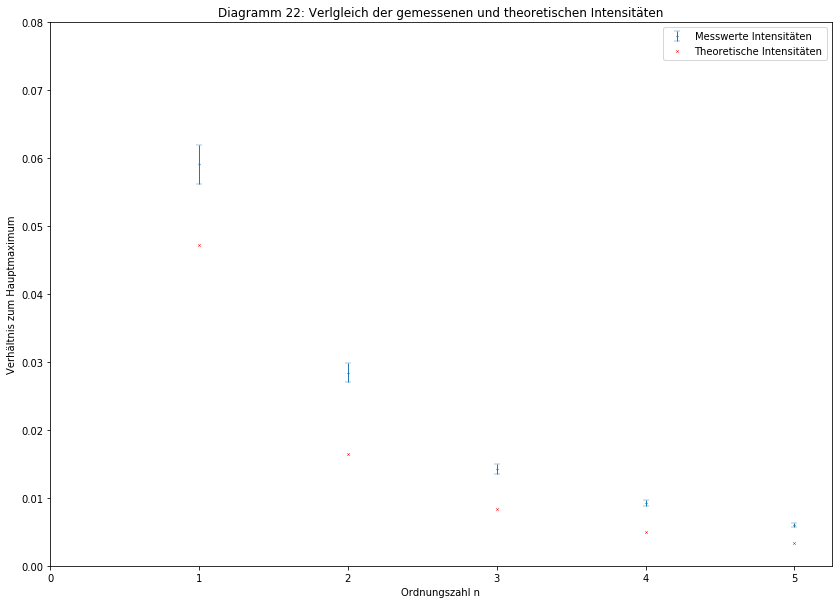

In [23]:
# plt.figure(figsize=(15,10))
plt.figure(figsize=(14, 10))
plt.errorbar(np.arange(0, 6), V0i, yerr=V0i_error, xerr=None,
             fmt=".", capsize=3, label="Messwerte Intensitäten")
plt.errorbar(np.arange(0, 6), V0i_theo, xerr=None, yerr=None, fmt="x",
             capsize=3, label="Theoretische Intensitäten", color='red')
plt.xlabel("Ordnungszahl n")
plt.ylabel("Verhältnis zum Hauptmaximum")
plt.xlim(0,)
plt.ylim(0, 0.08)
plt.legend()
plt.title("Diagramm 22: Verlgleich der gemessenen und theoretischen Intensitäten")
plt.savefig('fig/intensitätsverhältnisse.pdf')

## 3.2 Beugungsstruktur des Doppelspaltes

### Maße des Doppelspaltes (aus Aufgabe 4)

In [24]:
# Bildweite in mm:
b = 705.0
b_error = 20.0

# Gegenstandsweite
g_weite = 1/(1/f1 - 1/b)
g_weite_error = 1/(1/f1 - 1/b)**2 * 1/b**2 * b_error

# Vergrößerung von Objekt zu Bildebene:
vergroesserung = b/g_weite  # = 1 + b/f1
vergroesserung_error = b_error/f1

print('Gegenstandsweite g = ', g_weite, '+-', g_weite_error, 'mm')
print('Vergrößerung v = ', vergroesserung, '+-', vergroesserung_error)

Gegenstandsweite g =  90.24 +- 0.32767999999999997 mm
Vergrößerung v =  7.8125 +- 0.25


In [25]:
# Spaltabstand Mitte-Mitte in px:
g_px = np.mean([1219.54, 1358.17]) - np.mean([893.96, 1034.54])

# Für Spaltbreite in px Mittelwert aus beiden Spaltbreiten:
d2_px = np.mean([1034.54 - 893.96, 1358.17 - 1219.54])

g_px_error = np.sqrt(2)*px_error
d2_px_error = np.sqrt(2)*px_error

In [26]:
g = g_px*pxbreite/vergroesserung
g_error = g*np.sqrt((g_px_error/g_px)**2 +
                    (vergroesserung_error/vergroesserung)**2)

d2 = d2_px*pxbreite/vergroesserung
d2_error = d2*np.sqrt((d2_px_error/d2_px)**2 +
                      (vergroesserung_error/vergroesserung)**2)

print('Spaltabstand: g = ', g, ' +- ', g_error, ' mm')
print('Spaltbreite: d2 = ', d2, ' +- ', d2_error, ' mm')

Spaltabstand: g =  0.58169216  +-  0.019291880661604685  mm
Spaltbreite: d2 =  0.25017216000000003  +-  0.009475140540931475  mm


In [27]:
# Verhältnis von Spaltabstand zur Spaltbreite
v_gd2 = g/d2
v_gd2_error = v_gd2*np.sqrt((g_error/g)**2 + (d2_error/d2)**2)

print('Das Verhältnis v aus Spaltabstand g und Spaltbreite d2 beträgt damit: ')
print('v = ' + str(v_gd2) + ' +- ' + str(v_gd2_error))

Das Verhältnis v aus Spaltabstand g und Spaltbreite d2 beträgt damit: 
v = 2.3251674366963933 +- 0.11705550462127014


In [28]:
# Relative Fehler
print('Relative Fehler: ')
print('g_error/g = ', g_error/g)
print('d2_error/d2 = ', d2_error/d2)
print('v_gd2_error/v_gd2 = ', v_gd2_error/v_gd2)

Relative Fehler: 
g_error/g =  0.033165103448540005
d2_error/d2 =  0.03787448028162475
v_gd2_error/v_gd2 =  0.05034282812234075


### Berechnung der theoretisch zu erwartenden Beugungsstruktur des Doppelspaltes

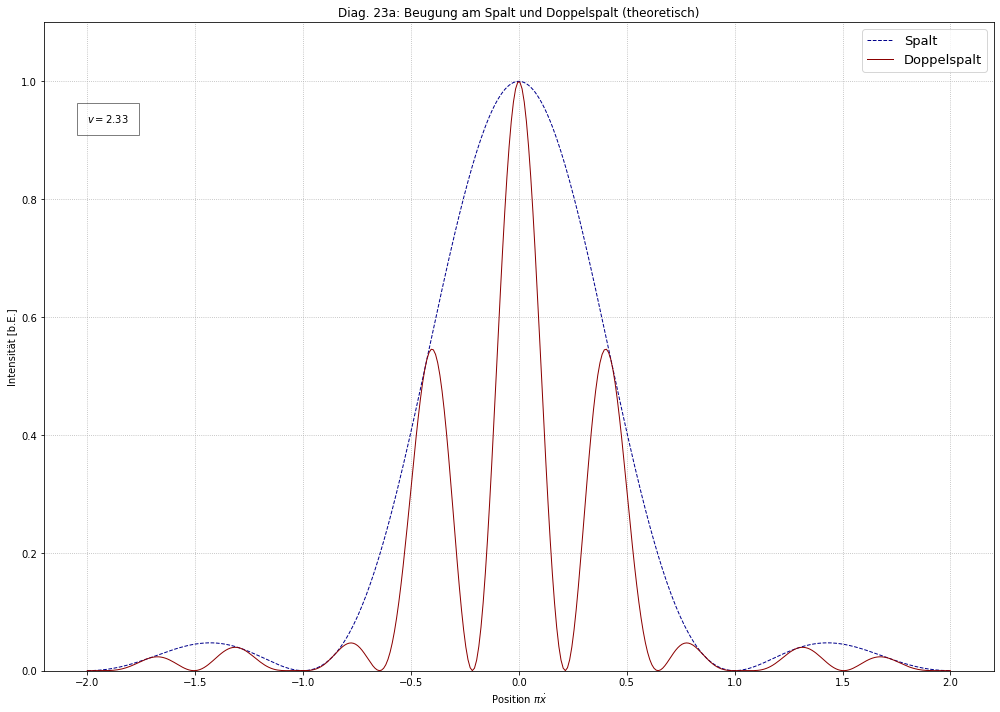

In [29]:
# Anzahl zu zeigender Nebenmaxima:
a = 1

x2 = np.linspace(-(a + 1), a + 1, 400)
intens_theo2 = beugung_doppelspalt(x2, g, d2)

plt.figure(figsize=(14, 10))
plt.plot(x2, beugung_spalt(x2), label='Spalt',
         color='darkblue', linestyle='--', marker='')
plt.plot(x2, intens_theo2, label='Doppelspalt', color='darkred', marker='')

# plt.figure(figsize=(15,10))
plt.xlabel('Position $\pi \dot x$')
plt.ylabel('Intensität [b.E.]')
plt.ylim((0, 1.1))
plt.legend(frameon=True, fontsize=13)
plt.grid(ls='dotted')
plt.text(-2, 0.93, r'$v = %.2f$' %
         v_gd2, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, size=10)
plt.title('Diag. 23a: Beugung am Spalt und Doppelspalt (theoretisch)')

plt.tight_layout()
plt.savefig('fig/beugung_spalt_doppelspalt.pdf', format='pdf')

Da sowohl die Spaltbreite als auch der Spaltabstand bzw. deren Verhältnis fehlerbehaftet sind, wird durch Einsetzen anderer Werte für d2 und g bzw. v_gd2 die Unsicherheit der theoretischen Werte bestimmt.
Für das Verhältnis werden die Randwerte des 1$\sigma$ Intervalls (v_gd2 $\pm$ v_gd2_error) in die Doppelspaltfunktion eingesetzt und für beide Randwerte nochmal die jeweiligen Plots betrachtet.

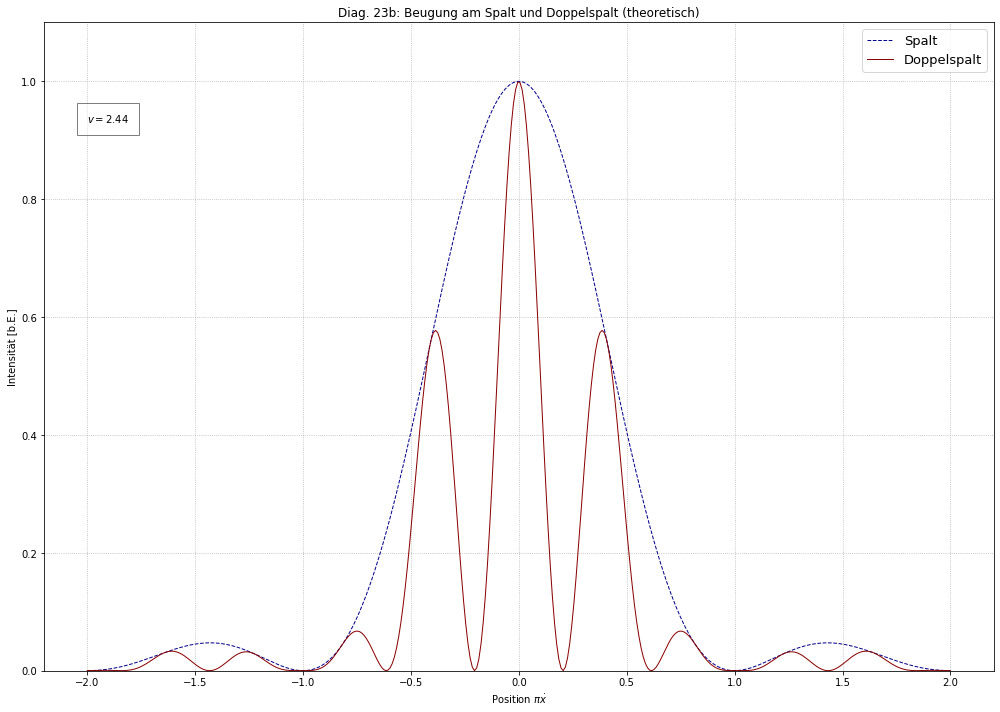

In [30]:
# Erster Vergleichsplot
intens_theo2_error1 = beugung_doppelspalt(x2, _v=v_gd2 + v_gd2_error)
#intens_theo2_test = beugung_doppelspalt(x2, g + g_error, d2 - d2_error)
plt.figure(figsize=(14, 10))

plt.plot(x2, beugung_spalt(x2), label='Spalt',
         color='darkblue', linestyle='--', marker='')
plt.plot(x2, intens_theo2_error1, label='Doppelspalt',
         color='darkred', marker='')

# plt.figure(figsize=(15,10))
plt.xlabel('Position $\pi \dot x$')
plt.ylabel('Intensität [b.E.]')
plt.ylim((0, 1.1))
plt.legend(frameon=True, fontsize=13)
plt.grid(ls='dotted')
plt.text(-2, 0.93, r'$v = %.2f$' % (v_gd2 + v_gd2_error),
         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, size=10)
plt.title('Diag. 23b: Beugung am Spalt und Doppelspalt (theoretisch)')

plt.tight_layout()
plt.savefig('fig/beugung_spalt_doppelspalt_error1.pdf', format='pdf')

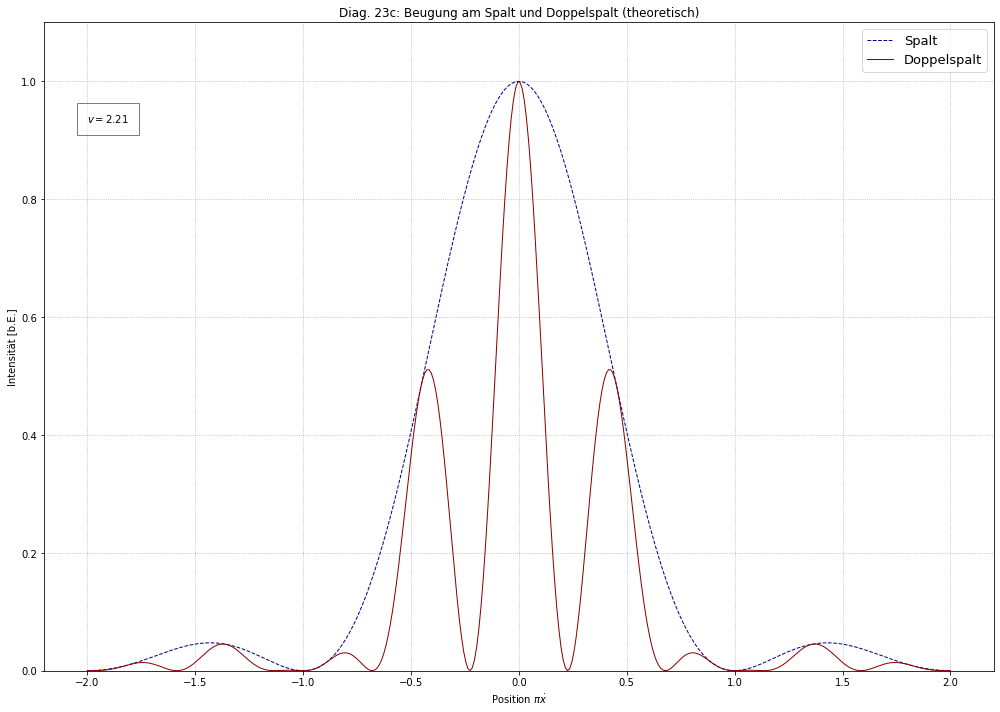

In [31]:
# Zweiter Vergleichsplot
intens_theo2_error2 = beugung_doppelspalt(x2, _v=v_gd2 - v_gd2_error)
#intens_theo2_test = beugung_doppelspalt(x2, g - g_error, d2 + d2_error)
plt.figure(figsize=(14, 10))

plt.plot(x2, beugung_spalt(x2), label='Spalt',
         color='darkblue', linestyle='--', marker='')
plt.plot(x2, intens_theo2_error2, label='Doppelspalt',
         color='darkred', marker='')

# plt.figure(figsize=(15,10))
plt.xlabel('Position $\pi \dot x$')
plt.ylabel('Intensität [b.E.]')
plt.ylim((0, 1.1))
plt.legend(frameon=True, fontsize=13)
plt.grid(ls='dotted')
plt.text(-2, 0.93, r'$v = %.2f$' % (v_gd2 - v_gd2_error),
         bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10}, size=10)
plt.title('Diag. 23c: Beugung am Spalt und Doppelspalt (theoretisch)')

plt.tight_layout()
plt.savefig('fig/beugung_spalt_doppelspalt_error2.pdf', format='pdf')

### Berechnung der Intensitätsverhältnisse der Nebenmaxima

In [32]:
# Numerische Bestimmung der theoretischen Maxima zwischen den 1. Minima der Spaltfunktion:
maxima_indices2, maxima_prop2 = find_peaks(intens_theo2, height=0.04)
nebenmaxima_theo2 = np.flip(maxima_prop2['peak_heights'][:2])

In [33]:
print('Relative Intensitaet der ersten beiden Nebenmaxima bezogen auf das zentrale Maximum: ')
print(np.flip(maxima_prop2['peak_heights'][:2]))

Relative Intensitaet der ersten beiden Nebenmaxima bezogen auf das zentrale Maximum: 
[0.54538709 0.04702568]


In [34]:
# Numerische Bestimmung der Fehler der theoretischen Maxima zwischen den 1. Minima der Spaltfunktion:
maxima_indices2_error1, maxima_prop2_error1 = find_peaks(
    intens_theo2_error1, height=0.04)
nebenmaxima_theo2_error1 = np.flip(maxima_prop2_error1['peak_heights'][:2])
nebenmaxima_theo2_error1 = np.abs(nebenmaxima_theo2 - nebenmaxima_theo2_error1)

maxima_indices2_error2, maxima_prop2_error2 = find_peaks(
    intens_theo2_error2, height=0.04)
nebenmaxima_theo2_error2 = np.flip(maxima_prop2_error2['peak_heights'][:2])
nebenmaxima_theo2_error2 = np.abs(nebenmaxima_theo2 - nebenmaxima_theo2_error2)

nebenmaxima_theo2_error = 0.5 * \
    (nebenmaxima_theo2_error1 + nebenmaxima_theo2_error2)

In [35]:
print('Fehler der relativen Intensitaet der ersten beiden Nebenmaxima bezogen auf das zentrale Maximum: ')
print(nebenmaxima_theo2_error)

print('Relativer Fehler der ersten beiden Nebenmaxima: ')
print(nebenmaxima_theo2_error/nebenmaxima_theo2)

Fehler der relativen Intensitaet der ersten beiden Nebenmaxima bezogen auf das zentrale Maximum: 
[0.03331153 0.0109511 ]
Relativer Fehler der ersten beiden Nebenmaxima: 
[0.06107868 0.23287491]


### Vergleich der theoretischen Werte mit den aufgenommenen Messwerten

In [36]:
# Gemessene Intensitäten der Maxima und Minima (Messreihe 3 / Tabelle 4)
m3_max = np.array([3696.00, 2559.50, 281.68])

# Werte der Untergrundintensität aus dem Messprotkoll (im Rahmen der Schwankungen links und rechts gleich)
untergrund = 80.0
untergrund_error = 2.0

In [37]:
# Korrektur der Messwerte mit der Untergrundintensität
m3_max_corr = m3_max - untergrund
m3_max_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_error**2), m3_max_corr.size)

In [38]:
# Berechnung der Verhältnisse zum Maximum 0. Ordnung
intens2 = m3_max_corr[1:] / m3_max_corr[0]
intens2_error = intens2 * \
    np.sqrt((m3_max_corr_error[1:]/m3_max_corr[1:])
            ** 2 + (m3_max_corr_error[0]/m3_max_corr[0])**2)

In [39]:
print('Gemessene Intensitaeten:')
print('Relative Intensitaet bezogen auf das zentrale Maximum:\n ', intens2)
print('Fehler der relativen Intensitaet: ', intens2_error)

print('Theoretische Intensitaeten: ')
print('Relative Intensitaet bezogen auf das zentrale Maximum:\n ', nebenmaxima_theo2)
print('Fehler der relativen Intensitaet: ', nebenmaxima_theo2_error)

print('Abweichung in Sigma: ')
print((intens2 - nebenmaxima_theo2) /
      np.sqrt(intens2_error**2 + nebenmaxima_theo2_error**2))

Gemessene Intensitaeten:
Relative Intensitaet bezogen auf das zentrale Maximum:
  [0.68570243 0.05577434]
Fehler der relativen Intensitaet:  [0.00341959 0.00282464]
Theoretische Intensitaeten: 
Relative Intensitaet bezogen auf das zentrale Maximum:
  [0.54538709 0.04702568]
Fehler der relativen Intensitaet:  [0.03331153 0.0109511 ]
Abweichung in Sigma: 
[4.19019544 0.77356558]


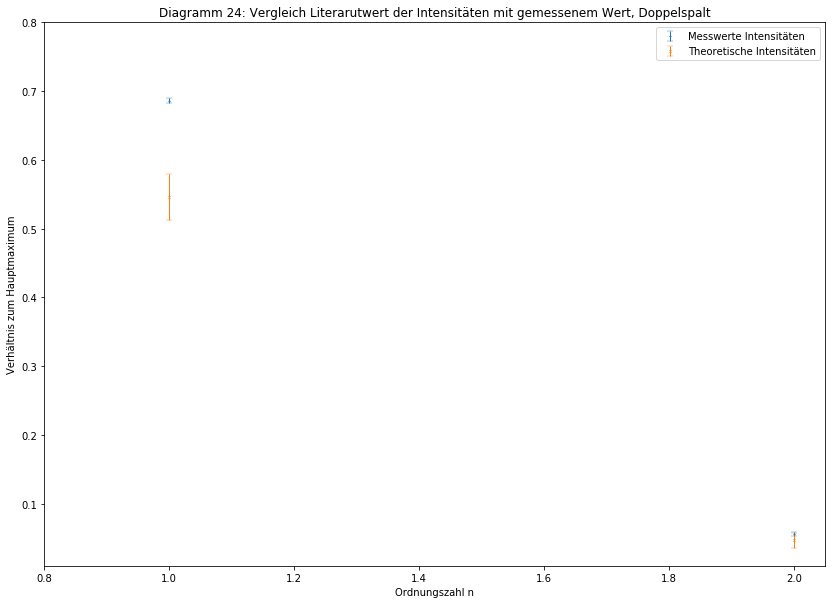

In [40]:
# plt.figure(figsize=(15,10))
plt.figure(figsize=(14, 10))
plt.title("Diagramm 24: Vergleich Literarutwert der Intensitäten mit gemessenem Wert, Doppelspalt")
plt.errorbar(np.array([1, 2]), intens2, yerr=intens2_error,
             xerr=None, fmt=".", capsize=3, label="Messwerte Intensitäten")
plt.errorbar(np.array([1, 2]), nebenmaxima_theo2, xerr=None,
             yerr=nebenmaxima_theo2_error, fmt="x", capsize=3, label="Theoretische Intensitäten")
plt.legend()
plt.ylim(0.01, 0.8)
plt.xlim(0.8,)
# plt.yscale('log')
plt.xlabel("Ordnungszahl n")
plt.ylabel("Verhältnis zum Hauptmaximum")
plt.savefig('fig/V233Diagramm24.pdf')

## 3.3 Objektbild als Fouriersynthese des Beugungsbildes

### Bestimmung der Spaltbreite

In [41]:
# Spaltbreite in px:
d_alt_kamera = (1153.45 - 1017.7)
d_alt_kamera_error = np.sqrt(2)*px_error

d_alt = d_alt_kamera*pxbreite/vergroesserung
d_alt_error = d_alt*np.sqrt((d_alt_kamera_error/d_alt_kamera)
                            ** 2 + (vergroesserung_error/vergroesserung)**2)
print('Spaltbreite Einzelspalt: d = ', d_alt, ' +- ', d_alt_error, ' mm')
print('Relativer Fehler: ', d_alt_error/d_alt)

diff = np.abs(d_alt - d)
print('Abweichung zu erster Messung: ', diff /
      np.sqrt(d_alt_error**2 + d_error**2), ' sigma')

Spaltbreite Einzelspalt: d =  0.243264  +-  0.009289119585014717  mm
Relativer Fehler:  0.03818534425568402
Abweichung zu erster Messung:  3.2521281742731007  sigma


### Vergleich mit den theoretischen Bildern

Wir berechnen zunächst die entsprechenden Bilder für die insgesamt sechs spezifischen Einstellungen des Analysierspaltes. (n = 1,2,3,4,5,15)

In [42]:
# Integrand für den Einfachspalt
def spalt(k, y, d):
    return d/np.pi * np.sin(k*d/2)/(k*d/2) * np.cos(k*y)

In [43]:
# Integrand für den Doppelspalt
def doppelspalt(k, y, d, g):
    return d/np.pi * np.sin(k*d/2)/(k*d/2) * np.cos(k*y) * np.cos(k*g/2)

In [44]:
def plotten(function, n, dateiname, speichername):

    # Spaltbreite auf 1 setzen
    d = 1

    # Spaltabstand in Einheiten der Spaltbreite
    g = 2*d

    # Integrationsbereich: bis zum n-ten Minimum
    if function == spalt:
        Y = np.linspace(-1, 1, 501)*d
        f_mod = np.empty(len(Y))
    else:
        Y = np.linspace(-1, 1, 201)*g
        f_mod = np.empty(len(Y))

    for i, y in enumerate(Y):
        if function == spalt:
            result, error = quad(lambda k: spalt(k, y, d), 0, 2*np.pi*n/d)
        else:
            result, error = quad(lambda k: doppelspalt(
                k, y, d, g), 0, 2*np.pi*n/d)

        f_mod[i] = result**2

    # Normieren auf das Maximum 0-ter Ordnung:
    max_0 = np.max(f_mod)
    f_mod = f_mod/max_0

    # Lage der Maxima
    max1 = argrelextrema(f_mod, np.greater_equal, order=1)
    f_max1 = f_mod[max1]
    y_max1 = Y[max1]
    max2 = (f_max1 > 0.05)
    f_max = f_max1[max2]
    y_max = y_max1[max2]

    # Lage der Minima
    min1 = argrelextrema(f_mod, np.less_equal, order=1)
    f_min1 = f_mod[min1]
    y_min1 = Y[min1]
    min2 = (f_min1 > 0.05)
    f_min = f_min1[min2]
    y_min = y_min1[min2]

    # Beugungsbild mitsamt Minima und Maxima plotten
    plt.figure(figsize=(14, 10))
    plt.figure(dateiname)
    plt.plot(Y, f_mod, color='darkgreen', linestyle='--', marker='')
    plt.plot(y_max, f_max, linestyle='', marker='x',
             color='darkblue', label='Maxima', markersize=7)
    plt.plot(y_min, f_min, linestyle='', marker='x',
             color='darkred', label='Minima', markersize=7)
    plt.xlabel('y / d', size=15)
    plt.ylabel('rel. Intensität [b. E.]', size=15)
    plt.title('Diagramm %s' % dateiname, size=13)
    plt.ylim((0, 1.1))
    plt.savefig('fig/%s.pdf' % speichername)

    # Rückgabe der Lage der Maxima und Minima
    return y_max, f_max, y_min, f_min

<Figure size 1008x720 with 0 Axes>

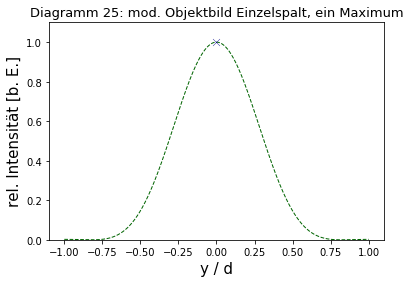

<Figure size 1008x720 with 0 Axes>

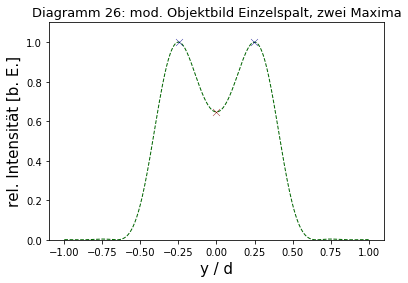

<Figure size 1008x720 with 0 Axes>

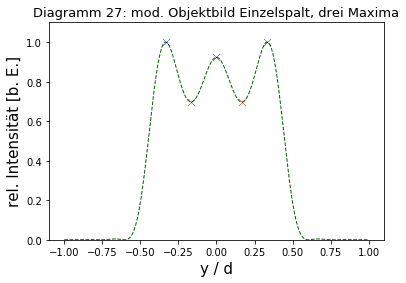

<Figure size 1008x720 with 0 Axes>

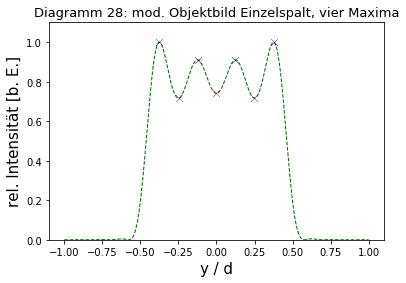

<Figure size 1008x720 with 0 Axes>

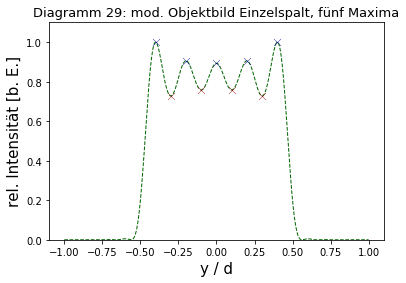

<Figure size 1008x720 with 0 Axes>

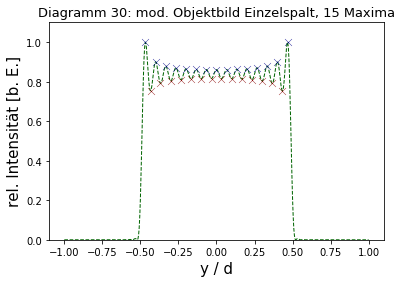

In [45]:
# Plotten der Einzelspaltbilder mittels der Funktion  plotten()
maxPos_spalt1, maxInt_spalt1, minPos_spalt1, minInt_spalt1 = plotten(
    spalt, 1, '25: mod. Objektbild Einzelspalt, ein Maximum', 'V233Diagramm25')
maxPos_spalt2, maxInt_spalt2, minPos_spalt2, minInt_spalt2 = plotten(
    spalt, 2, '26: mod. Objektbild Einzelspalt, zwei Maxima', 'V233Diagramm26')
maxPos_spalt3, maxInt_spalt3, minPos_spalt3, minInt_spalt3 = plotten(
    spalt, 3, '27: mod. Objektbild Einzelspalt, drei Maxima', 'V233Diagramm27')
maxPos_spalt4, maxInt_spalt4, minPos_spalt4, minInt_spalt4 = plotten(
    spalt, 4, '28: mod. Objektbild Einzelspalt, vier Maxima', 'V233Diagramm28')
maxPos_spalt5, maxInt_spalt5, minPos_spalt5, minInt_spalt5 = plotten(
    spalt, 5, '29: mod. Objektbild Einzelspalt, fünf Maxima', 'V233Diagramm29')
maxPos_spalt15, maxInt_spalt15, minPos_spalt15, minInt_spalt15 = plotten(
    spalt, 15, '30: mod. Objektbild Einzelspalt, 15 Maxima', 'V233Diagramm30')

### Bestimmung der Abstände der "Wiggels"  (der Maxima) für die Ordnung 2 und 3

In [46]:
# Abstände zwischen den Maxima gemessen in y/d:
# n = 2:
dist_max_2 = np.diff([1049.63, 1121.89]) / d_alt_kamera
dist_max_2_error = dist_max_2 * np.sqrt((np.sqrt(2)*px_error/np.diff([1049.63, 1121.89]))**2 +
                                        (d_alt_kamera_error/d_alt_kamera)**2)
# n = 3:
dist_max_3 = np.diff([1039.03, 1086.88, 1134.74]) / d_alt_kamera
dist_max_3_error = dist_max_3 * np.sqrt((np.sqrt(2)*px_error/np.diff([1039.03, 1086.88, 1134.74]))**2 +
                                        (d_alt_kamera_error/d_alt_kamera)**2)

In [47]:
# Maxima der theoretischen Bilder bereits in Einheiten von y/d_alt
# unter maxPos_spalt und maxInt_spalt gespeichert
dist_theo_2 = np.diff(maxPos_spalt2)
dist_theo_3 = np.diff(maxPos_spalt3)

In [48]:
print(dist_max_2_error)
print(dist_max_3_error)
print('Abstände zwischen zwei Maxima in Einheiten von d_alt')
print('n = 2 (gemessen): ', dist_max_2)
print('      (theoretisch): ', dist_theo_2)
print('      Abweichung: ', (dist_max_2 - dist_theo_2)/dist_max_2_error)
print('n = 3 (gemessen): ', dist_max_3)
print('      (theoretisch): ', dist_theo_3)
print('     Abweichung: ', (dist_max_3 - dist_theo_3)/dist_max_3_error)

[0.02360353]
[0.02209205 0.02209256]
Abstände zwischen zwei Maxima in Einheiten von d_alt
n = 2 (gemessen):  [0.53230203]
      (theoretisch):  [0.496]
      Abweichung:  [1.53799144]
n = 3 (gemessen):  [0.35248619 0.35255985]
      (theoretisch):  [0.332 0.332]
     Abweichung:  [0.92731059 0.93062355]


### Bestimmung der Abstände der "Wiggels" (Maxima) bei höherer Ordnung

In [49]:
maxima_pos = np.array([1022.8, 1033.0, 1042.45, 1050.4, 1059.1, 1067.95, 1076.95, 1085.95,
                       1094.35, 1103.35, 1111.6, 1119.7, 1129.6, 1138.0, 1147.9])  # Px
minima_pos = np.array([1028.5, 1036.9, 1045.6, 1055.2, 1063.75, 1072.9, 1080.85, 1090.3,
                       1098.4, 1107.25, 1115.05, 1124.5, 1133.05, 1142.5])  # Px

maxima_diff = np.diff(maxima_pos)
minima_diff = np.diff(minima_pos)

print('Abstände zweier aufeinanderfolgender Maxima in Px:\n ', maxima_diff)
print('Abstände zweier aufeinanderfolgender Minima in Px:\n ', minima_diff)
print('Mittelwert Maximaabstand in Px: ', np.mean(maxima_diff))
print('Mittelwert Minimaabstand in Px: ', np.mean(minima_diff))
print('Standardabweichung Maximaabstand in Px: ', np.std(maxima_diff))
print('Standardabweichung Minimaabstand in Px: ', np.std(minima_diff))

Abstände zweier aufeinanderfolgender Maxima in Px:
  [10.2   9.45  7.95  8.7   8.85  9.    9.    8.4   9.    8.25  8.1   9.9
  8.4   9.9 ]
Abstände zweier aufeinanderfolgender Minima in Px:
  [8.4  8.7  9.6  8.55 9.15 7.95 9.45 8.1  8.85 7.8  9.45 8.55 9.45]
Mittelwert Maximaabstand in Px:  8.935714285714296
Mittelwert Minimaabstand in Px:  8.76923076923077
Standardabweichung Maximaabstand in Px:  0.6820213055502594
Standardabweichung Minimaabstand in Px:  0.59015593165594


In [50]:
all_pos = np.empty(maxima_pos.size + minima_pos.size)
all_pos[0::2] = maxima_pos
all_pos[1::2] = minima_pos

all_diff = np.diff(all_pos)

print('Alle Abstände in Px:\n ', all_diff)
print('Mittelwert aller Abstände in Px: ', np.mean(all_diff))
print('Standardabweichung aller Abstände in Px: ', np.std(all_diff))

Alle Abstände in Px:
  [5.7  4.5  3.9  5.55 3.15 4.8  4.8  3.9  4.65 4.2  4.95 4.05 3.9  5.1
 4.35 4.05 4.05 4.95 3.9  4.35 3.45 4.65 4.8  5.1  3.45 4.95 4.5  5.4 ]
Mittelwert aller Abstände in Px:  4.467857142857148
Standardabweichung aller Abstände in Px:  0.6317795566202528


Text(0.5, 1.0, 'Histogramm 1:  Überprüfung auf Äquidistanz')

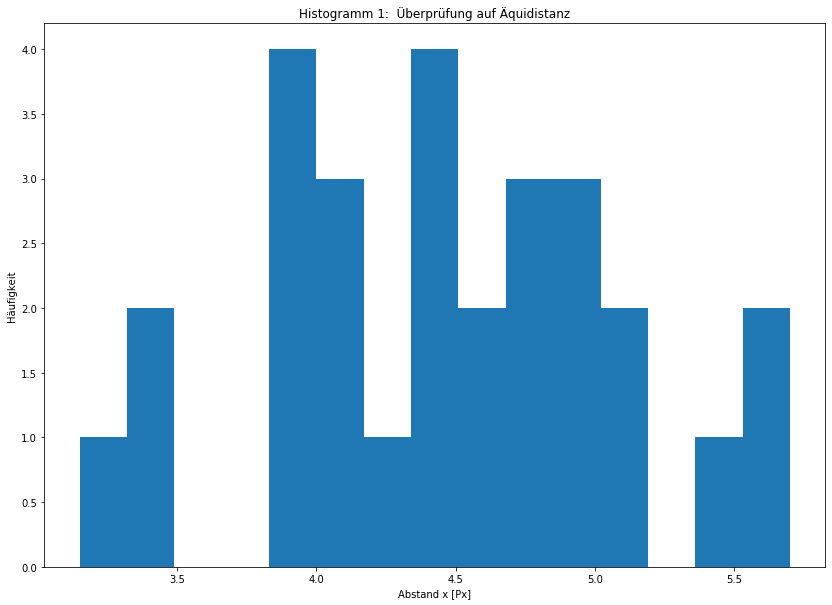

In [51]:
plt.figure(figsize=(14, 10))
plt.hist(all_diff, bins=15)
plt.xlabel('Abstand x [Px]')
plt.ylabel('Häufigkeit')
plt.title('Histogramm 1:  Überprüfung auf Äquidistanz')

### Bestimmung und Vergleich der relativen Intensitäten der Extrema 

In [52]:
# Intensitäten der Maxima und Minima:
intens_max_1 = np.array([3754.0])

intens_max_2 = np.array([3721.25, 3661.45])
intens_min_2 = np.array([2837.86])
intens_max_3 = np.array([3670.68, 3368.46, 3588.30])
intens_min_3 = np.array([3176.13, 3090.88])

# Werte der Untergrundintensität aus dem Messprotkoll (im Rahmen der Schwankungen links und rechts gleich)
untergrund_1 = 94.0
untergrund_2 = 94.0
untergrund_3 = 95.0

untergrund_1_error = 4.0
untergrund_2_error = 5.0
untergrund_3_error = 5.0

In [53]:
# Korrektur der Messwerte mit der Untergrundintensität
intens_max_1_corr = intens_max_1 - untergrund_1
intens_max_2_corr = intens_max_2 - untergrund_2
intens_min_2_corr = intens_min_2 - untergrund_2
intens_max_3_corr = intens_max_3 - untergrund_3
intens_min_3_corr = intens_min_3 - untergrund_3

intens_max_1_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_1_error**2), intens_max_1_corr.size)
intens_max_2_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_2_error**2), intens_max_2_corr.size)
intens_min_2_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_2_error**2), intens_min_2_corr.size)
intens_max_3_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_3_error**2), intens_max_3_corr.size)
intens_min_3_corr_error = np.repeat(
    np.sqrt(cnts_error**2 + untergrund_3_error**2), intens_min_3_corr.size)

In [54]:
# Bestimmung der relativen Intensitäten
max2_intens = intens_max_2_corr / intens_max_1_corr
min2_intens = intens_min_2_corr / intens_max_1_corr
max3_intens = intens_max_3_corr / intens_max_1_corr
min3_intens = intens_min_3_corr / intens_max_1_corr

max2_intens_error = max2_intens * \
    np.sqrt((intens_max_2_corr_error/intens_max_2_corr)**2 +
            (intens_max_1_corr_error/intens_max_1_corr)**2)
min2_intens_error = min2_intens * \
    np.sqrt((intens_min_2_corr_error/intens_min_2_corr)**2 +
            (intens_max_1_corr_error/intens_max_1_corr)**2)
max3_intens_error = max3_intens * \
    np.sqrt((intens_max_3_corr_error/intens_max_3_corr)**2 +
            (intens_max_1_corr_error/intens_max_1_corr)**2)
min3_intens_error = min3_intens * \
    np.sqrt((intens_min_3_corr_error/intens_min_3_corr)**2 +
            (intens_max_1_corr_error/intens_max_1_corr)**2)

In [55]:
def spalt(k, y):
    return d_alt/np.pi * np.sin(k*d_alt/2)/(k*d_alt/2) * np.cos(k*y)

In [56]:
# Bestimmung der rel. Intensitäten der theoretischen Minima und Maxima
Y = np.linspace(-1, 1, 501)*d_alt
f_mod = np.empty((3, len(Y)))

for n in range(1, 4):
    for i, y in enumerate(Y):
        result, error = quad(lambda k: spalt(k, y), 0, 2*np.pi*n/d_alt)
        f_mod[n - 1, i] = result**2
# Normieren auf Maximum 0-ter Ordnung:
max_0 = np.max(f_mod[0])
for n in range(1, 4):
    f_mod[n - 1] = f_mod[n - 1]/max_0

# n = 2
peaks_theo_2, max_heights_2 = find_peaks(f_mod[1], height=0.5)
max_heights_2 = max_heights_2['peak_heights']
mins_theo_2, min_heights_2 = find_peaks(-f_mod[1], height=(-1, -0.5))
min_heights_2 = -min_heights_2['peak_heights']

# n = 3
peaks_theo_3, max_heights_3 = find_peaks(f_mod[2], height=0.5)
max_heights_3 = max_heights_3['peak_heights']
mins_theo_3, min_heights_3 = find_peaks(-f_mod[2], height=(-1, -0.5))
min_heights_3 = -min_heights_3['peak_heights']

In [57]:
print('n = 2:')
print('Maxima (gemessen): ', max2_intens, '+/-', max2_intens_error)
print('       (theoretisch): ', max_heights_2)
print('       Abweichung: ', np.abs(
    max2_intens - maxInt_spalt2)/max2_intens_error)
print('Minima (gemessen): ', min2_intens, '+/-', min2_intens_error)
print('       (theoretisch): ', min_heights_2)
print('       Abweichung: ', np.abs(
    min2_intens - minInt_spalt2)/min2_intens_error)

print('n = 3:')
print('Maxima (gemessen): ', max3_intens, '+/-', max3_intens_error)
print('       (theoretisch): ', max_heights_3)
print('       Abweichung: ', np.abs(
    max3_intens - maxInt_spalt3)/max3_intens_error)
print('Minima (gemessen): ', min3_intens, '+/-', min3_intens_error)
print('       (theoretisch): ', min_heights_3)
print('       Abweichung: ', np.abs(
    min3_intens - minInt_spalt3)/min3_intens_error)

n = 2:
Maxima (gemessen):  [0.99105191 0.97471311] +/- [0.00422335 0.0041903 ]
       (theoretisch):  [0.90654929 0.90654929]
       Abweichung:  [2.11871692 6.03463119]
Minima (gemessen):  [0.74968852] +/- [0.00376807]
       (theoretisch):  [0.58639852]
       Abweichung:  [27.2929157]
n = 3:
Maxima (gemessen):  [0.97696175 0.89438798 0.95445355] +/- [0.00419483 0.00403218 0.00414971]
       (theoretisch):  [0.88570268 0.81781232 0.88570268]
       Abweichung:  [ 5.49206195  7.18237496 10.97580556]
Minima (gemessen):  [0.8418388  0.81854645] +/- [0.00393299 0.00389018]
       (theoretisch):  [0.61743243 0.61743243]
       Abweichung:  [36.79862757 31.21609761]


## 3.4 Fourierbild des Doppelspaltes

Bereits in Aufgabenteil 2 wurde der Spaltabstand g sowie die Breite d2 der Einzelspalte des verwendeten Doppelspaltes bestimmt. Wir ermitteln daher zunächst die theoretischen Beugungsbilder, bevor diese mit den experimentell gewonnenen verglichen werden.

<Figure size 1008x720 with 0 Axes>

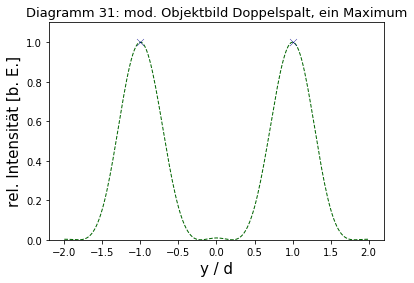

<Figure size 1008x720 with 0 Axes>

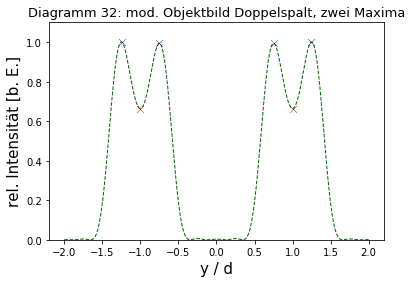

<Figure size 1008x720 with 0 Axes>

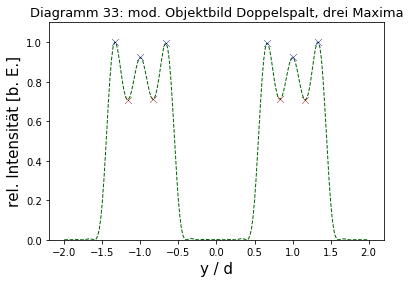

<Figure size 1008x720 with 0 Axes>

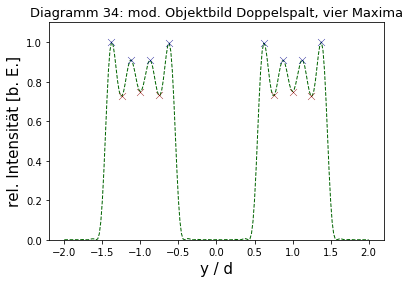

<Figure size 1008x720 with 0 Axes>

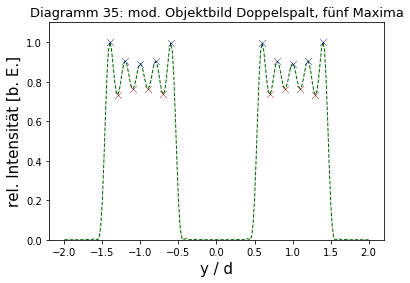

<Figure size 1008x720 with 0 Axes>

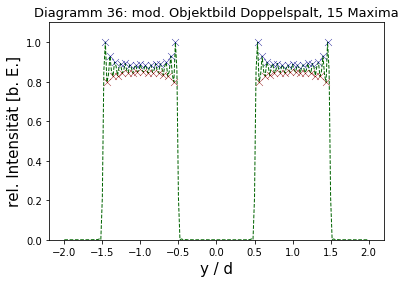

In [58]:
# Plotten der Doppelspaltbilder mit in Aufgabenteil 2
# berechnetem d und g  mittels der Funktion  plotten()
maxPos_dspalt1, maxInt_dspalt1, minPos_dspalt1, minInt_dspalt1 = plotten(
    doppelspalt, 1, '31: mod. Objektbild Doppelspalt, ein Maximum', 'V233Diagramm31')
maxPos_dspalt2, maxInt_dspalt2, minPos_dspalt2, minInt_dspalt2 = plotten(
    doppelspalt, 2, '32: mod. Objektbild Doppelspalt, zwei Maxima', 'V233Diagramm32')
maxPos_dspalt3, maxInt_dspalt3, minPos_dspalt3, minInt_dspalt3 = plotten(
    doppelspalt, 3, '33: mod. Objektbild Doppelspalt, drei Maxima', 'V233Diagramm33')
maxPos_dspalt4, maxInt_dspalt4, minPos_dspalt4, minInt_dspalt4 = plotten(
    doppelspalt, 4, '34: mod. Objektbild Doppelspalt, vier Maxima', 'V233Diagramm34')
maxPos_dspalt5, maxInt_dspalt5, minPos_dspalt5, minInt_dspalt5 = plotten(
    doppelspalt, 5, '35: mod. Objektbild Doppelspalt, fünf Maxima', 'V233Diagramm35')
maxPos_dspalt15, maxInt_dspalt15, minPos_dspalt15, minInt_dspalt15 = plotten(
    doppelspalt, 15, '36: mod. Objektbild Doppelspalt, 15 Maxima', 'V233Diagramm36')

### Fall a) 

In diesem Fall tragen nur noch die 1. Beugungsmaxima beider Spalte zur Abbildung bei. Wir wählen daher das 1. Spaltminimum als obere Integrationsgrenze: 
$k_{y,1} = k_0 \sin(\alpha_n) = k_0n\lambda /d = 2n\pi /d
\overset{\text{n = 1}}{{=}} 2\pi /d$ <br>
$k_{y,1} = k_0 \sin(\alpha) = 2\pi/\lambda \sin(\alpha) = \frac{2\pi a}{\lambda f_1}$

In [59]:
messuhr_a = 0.220  # mm
messuhr_a_error = 0.0005  # mm

ky1_theo = 2*np.pi/d2  # 1/mm
ky1_theo_error = ky1_theo*d2_error/d2  # 1/mm

ky1_exp = 2*np.pi*messuhr_a/(lamb*f1)
ky1_exp_error = ky1_exp*messuhr_a_error/messuhr_a

ky1_diff = np.abs(ky1_theo - ky1_exp)
ky1_diff_error = np.sqrt(ky1_theo_error**2 + ky1_exp_error**2)
ky1_sig = ky1_diff/ky1_diff_error

In [60]:
print('Fall a):')
print('ky1_theo = ', ky1_theo, "+/-", ky1_theo_error, ' 1/mm')
print('ky1_exp = ', ky1_exp, "+/-", ky1_exp_error, ' 1/mm')
print('Abweichung in Sigma:', ky1_sig)

Fall a):
ky1_theo =  25.115445728172094 +/- 0.9512344539958707  1/mm
ky1_exp =  27.210645031092692 +/- 0.06184237507066521  1/mm
Abweichung in Sigma: 2.1979706842875215


### Fall b)

In diesem Fall verschwindet die Doppelstruktur endgültig und nur noch ein flaches Plateau bleibt sichtbar. Auch die dem Doppelspalt zugeordneten 1. Gittermaxima werden abgeschnitten. Um Fall b) zu simulieren, verschaffen wir uns für verschiedene Werte von $k_y$ nahe dem Wert $k_y = k_0 \sin(\alpha) = k_0 \lambda / g$ die  zugehörigen Bilder und arbeiten durch Iteration auf einen Wert hin, der gerade die experimentell bestimmte Struktur wiedergibt.

In [61]:
def doppelspalt(k, y):
    return d2/np.pi * np.sin(k*d2/2)/(k*d2/2) * np.cos(k*y) * np.cos(k*g/2)

In [62]:
Y_ = np.linspace(-2, 2, 200)*d2

f_mod_b = np.empty(Y_.size)
f_mod_b_2 = np.empty(Y_.size)
f_mod_b_3 = np.empty(Y_.size)

In [63]:
def doppelspalt(k, y):
    return d2/np.pi * np.sin(k*d2/2)/(k*d2/2) * np.cos(k*y) * np.cos(k*g/2)

In [75]:
n = 0.290
n_error = 0.005

kyn_theo = 2*n*np.pi/d2
kyn_theo_error = kyn_theo*np.sqrt((d2_error/d2)**2 + (n_error/n)**2)

for i, y in enumerate(Y_):
    result, error = quad(lambda k: doppelspalt(k, y), 0, kyn_theo)
    f_mod_b[i] = result**2

# Vergleichswerte
kyn_theo_2 = (n - 0.005) * 2*np.pi/d2
for i, y in enumerate(Y_):
    result_2, error_2 = quad(lambda k: doppelspalt(k, y), 0, kyn_theo_2)
    f_mod_b_2[i] = result_2**2

kyn_theo_3 = (n + 0.005) * 2*np.pi/d2
for i, y in enumerate(Y_):
    result_3, error_3 = quad(lambda k: doppelspalt(k, y), 0, kyn_theo_3)
    f_mod_b_3[i] = result_3**2

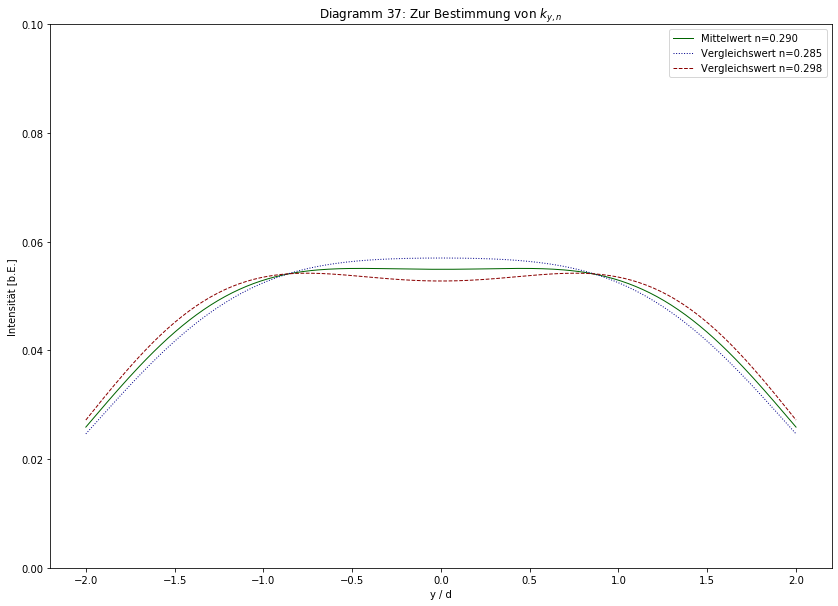

In [76]:
# plt.figure(figsize=(15,10))
plt.figure(figsize=(14, 10))
plt.plot(Y_/d2, f_mod_b, marker='', color='darkgreen',
         label='Mittelwert n=0.290')
plt.plot(Y_/d2, f_mod_b_2, marker='', linestyle=":",
         color="darkblue", label='Vergleichswert n=0.285')
plt.plot(Y_/d2, f_mod_b_3, marker='', linestyle="--",
         color="darkred", label='Vergleichswert n=0.298')
plt.ylim((0, 0.1))
plt.xlabel('y / d')
plt.ylabel('Intensität [b.E.]')
plt.legend()
plt.title('Diagramm 37: Zur Bestimmung von $k_{y,n}$')
plt.savefig('fig/V233Diagramm37.pdf')

In [77]:
messuhr_b = 0.065  # mm
messuhr_b_error = 0.0005  # mm

kyn_exp = 2*np.pi*messuhr_b/(lamb*f1)
kyn_exp_error = kyn_exp*messuhr_b_error/messuhr_b

In [78]:
kyn_diff = np.abs(kyn_theo - kyn_exp)
kyn_diff_error = np.sqrt(kyn_theo_error**2 + kyn_exp_error**2)
kyn_sig = kyn_diff/kyn_diff_error

In [79]:
print('Fall b):')
print('kyn_theo = ', kyn_theo, "+/-", kyn_theo_error, ' 1/mm')
print('kyn_exp = ', kyn_exp, "+/-", kyn_exp_error, ' 1/mm')
print('Abweichung in Sigma:', kyn_sig)

Fall b):
kyn_theo =  7.283479261169907 +/- 0.3030961430225513  1/m
kyn_exp =  8.039508759186479 +/- 0.061842375070665215  1/m
Abweichung in Sigma: 2.444001619399247
